
# Titanic — Interpretabilidade com **SHAP** (passo a passo)

Este notebook mostra como **explicar modelos** usando **SHAP** no problema do Titanic, com foco didático para alunos:
1. Preparação do dataset e **pipeline** (imputação + OHE).
2. Treino de **três modelos** (LR, RF, GB) e escolha de um para explicar.
3. **SHAP global**: quais features mais impactam a previsão?
4. **SHAP local**: por que este passageiro foi classificado assim?
5. Dicas de **boas práticas** e pegadinhas (OHE, escala, amostragem de background).

> Pré‑requisitos (em um terminal/venv):
```bash
pip install shap scikit-learn pandas numpy matplotlib
```


## 1) Imports e setup

In [65]:

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score

import shap
shap.__version__


'0.48.0'

## 2) Carregar dados e dividir treino/validação

In [66]:

DATA_DIR = Path('.')
train_path = DATA_DIR / 'train.csv'
assert train_path.exists(), 'Coloque o train.csv do Titanic em ./data/train.csv'

df = pd.read_csv(train_path)
TARGET = 'Survived'

FEATURES_NUM = ['Age','SibSp','Parch','Fare']
FEATURES_CAT = ['Pclass','Sex','Embarked']
FEATURES_ALL = FEATURES_NUM + FEATURES_CAT

X = df[FEATURES_ALL].copy()
y = df[TARGET].values

# Holdout didático só para visualização (usaremos também CV para comparar modelos)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_tr.shape, X_val.shape


((668, 7), (223, 7))

## 3) Pipeline de pré‑processamento

In [67]:

numeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])
categorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])
pre = ColumnTransformer(
    transformers=[
        ('num', numeric, FEATURES_NUM),
        ('cat', categorical, FEATURES_CAT),
    ]
)
pre


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## 4) Treinar três modelos (LR, RF, GB) e escolher o melhor (AUC CV)

In [68]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'LR': LogisticRegression(max_iter=1000, random_state=42),
    'RF': RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1),
    'GB': GradientBoostingClassifier(random_state=42)
}

from sklearn.pipeline import Pipeline as SkPipe

scores = {}
pipes = {}
for name, clf in models.items():
    pipe = SkPipe([('prep', pre), ('clf', clf)])
    auc = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1).mean()
    scores[name] = auc
    pipes[name] = pipe

scores_sorted = dict(sorted(scores.items(), key=lambda kv: kv[1], reverse=True))
scores_sorted


{'RF': 0.8726682152717491, 'GB': 0.8706320697768174, 'LR': 0.8513981884591237}

### Ajuste final do melhor modelo para explicação

In [69]:

best_name = max(scores, key=scores.get)
best_pipe = pipes[best_name]
best_pipe.fit(X_tr, y_tr)

print('Melhor modelo:', best_name, '| AUC(holdout):', round(roc_auc_score(y_val, best_pipe.predict_proba(X_val)[:,1]), 4))
best_name


Melhor modelo: RF | AUC(holdout): 0.8178


'RF'


## 5) Preparar **matriz de features** e **nomes das colunas** pós‑OHE

Para explicar com SHAP, precisamos das **features tabulares após o `ColumnTransformer`** (numéricas + dummies do OHE).


In [70]:

# Transforma o conjunto (usaremos todo X para um panorama global)
Xt = best_pipe.named_steps['prep'].transform(X)

# Nomes das colunas após OHE
ohe = best_pipe.named_steps['prep'].named_transformers_['cat'].named_steps['ohe']
cat_names = list(ohe.get_feature_names_out(FEATURES_CAT))
feature_names = FEATURES_NUM + cat_names
len(feature_names), feature_names[:10]


(12,
 ['Age',
  'SibSp',
  'Parch',
  'Fare',
  'Pclass_1',
  'Pclass_2',
  'Pclass_3',
  'Sex_female',
  'Sex_male',
  'Embarked_C'])


## 6) **SHAP global** (importância média e distribuição)

- Usaremos `shap.TreeExplainer` se o melhor modelo for de árvores (**RF**/**GB**).  
- Se for **LR**, podemos usar `shap.Explainer` com máscara/background.
- Para performance, amostramos um **background** pequeno (ex.: 200 linhas).


In [71]:

# Seleciona background para o kernel/masked (quando necessário)
idx_bg = np.random.RandomState(42).choice(np.arange(Xt.shape[0]), size=min(200, Xt.shape[0]), replace=False)
background = Xt[idx_bg]

model = best_pipe.named_steps['clf']

if best_name in ('RF','GB'):
    # Modelos de árvore → TreeExplainer é mais rápido/preciso
    explainer = shap.TreeExplainer(model, feature_names=feature_names, feature_perturbation='interventional')
    shap_values = explainer.shap_values(Xt)    
    # Para binário, TreeExplainer retorna lista [classe0, classe1]; usamos classe1
    if isinstance(shap_values, list) and len(shap_values) == 2:
        sv = shap_values[1]
    else:
        sv = shap_values
else:
    # Modelos genéricos → Explainer com background
    explainer = shap.Explainer(model.predict_proba, background)  # passa função proba
    sv = explainer(Xt)  # retorna Explanation com .values

type(sv), (np.array(sv).shape if hasattr(sv,'shape') else (sv.values.shape if hasattr(sv,'values') else 'n/a'))


/home/vinicius/.local/lib/python3.10/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


(numpy.ndarray, (891, 12, 2))

### 6.1. Summary plot (beeswarm) — impacto por feature

<Figure size 1000x500 with 0 Axes>

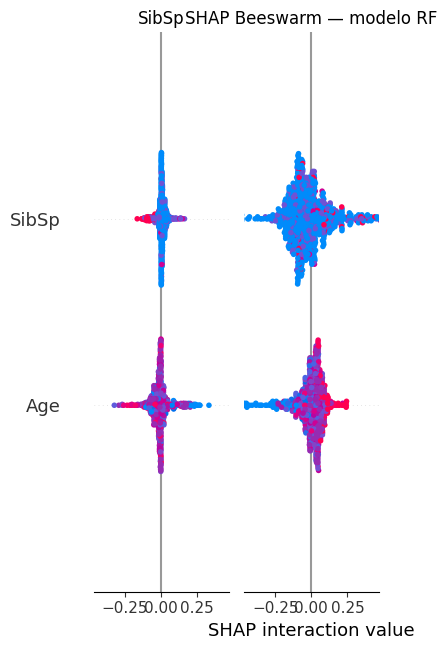

In [72]:

shap.initjs()
plt.figure(figsize=(10,5))
# Para objetos Explanation, shap.plots.beeswarm aceita o objeto direto; para array, usamos summary_plot clássico:
try:
    shap.plots.beeswarm(sv, show=False)
except Exception:
    shap.summary_plot(sv, features=Xt, feature_names=feature_names, show=False)
plt.title(f'SHAP Beeswarm — modelo {best_name}')
plt.tight_layout()
plt.show()


### 6.2. Bar plot — importância média absoluta (global)

<Figure size 800x500 with 0 Axes>

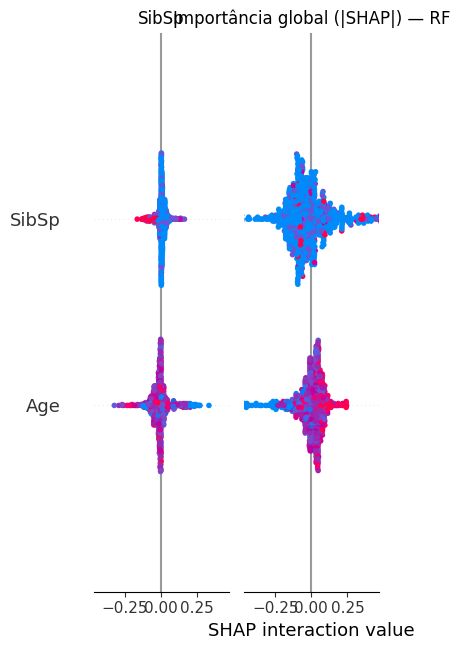

In [73]:

plt.figure(figsize=(8,5))
try:
    shap.plots.bar(sv, show=False)
except Exception:
    shap.summary_plot(sv, features=Xt, feature_names=feature_names, plot_type='bar', show=False)
plt.title(f'Importância global (|SHAP|) — {best_name}')
plt.tight_layout()
plt.show()



## 7) **SHAP local** (explicando um passageiro)

Vamos escolher uma observação de validação e explicar sua previsão.  
- `force_plot` ilustra **como cada feature empurrou** a probabilidade para cima/baixo.  
- Também mostraremos um **waterfall plot** (quando disponível).


/home/vinicius/.local/lib/python3.10/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


Waterfall não disponível, fallback para force_plot: list index out of range


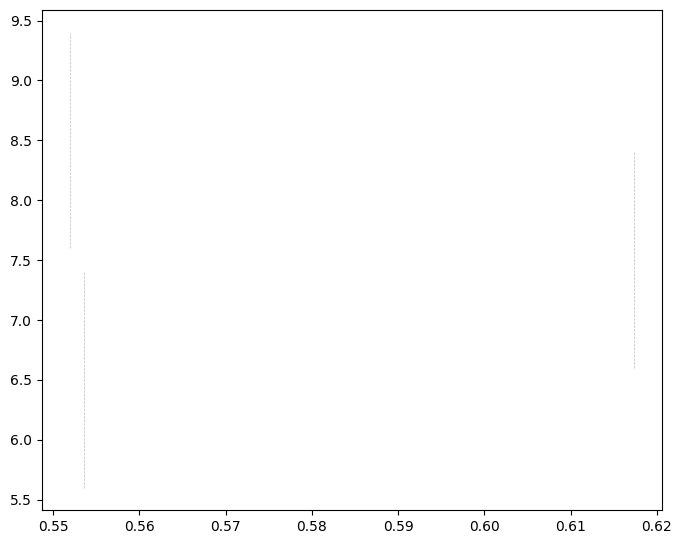

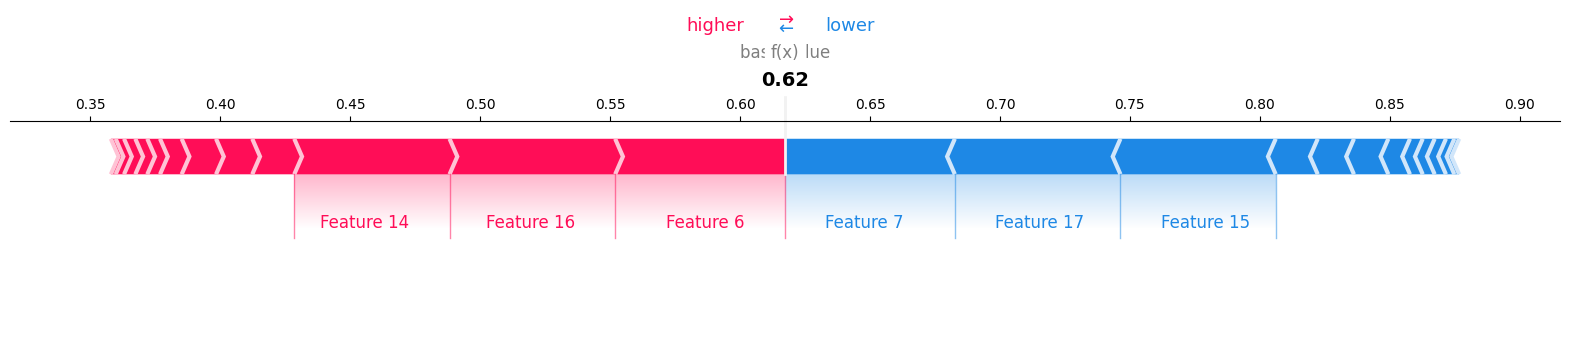

In [74]:
import numpy as np, shap, matplotlib.pyplot as plt

def _single_waterfall_from_tree(model, Xt_full, i_sample, feature_names):
    # TreeExplainer
    exp = shap.TreeExplainer(model, feature_names=feature_names, feature_perturbation='interventional')
    sv = exp.shap_values(Xt_full)  # pode ser lista [class0, class1] ou array
    # expected_value pode ser escalar, lista ou array
    ev = exp.expected_value

    # Seleciona classe 1 (positiva) quando retornar lista
    if isinstance(sv, list):
        # binário: [0,1]; multi-classe: lista maior. Aqui usamos classe positiva 1 se existir
        cls_idx = 1 if len(sv) > 1 else 0
        sv_sample = sv[cls_idx][i_sample]
        # expected value correspondente
        if isinstance(ev, (list, tuple, np.ndarray)):
            base_value = ev[cls_idx]
        else:
            base_value = ev
    else:
        # retorno já é array [n_amostras, n_features]
        sv_sample = sv[i_sample]
        base_value = ev if not isinstance(ev, (list, tuple, np.ndarray)) else ev[0]

    # Garante vetor 1D
    sv_sample = np.array(sv_sample).ravel()

    # Tenta waterfall; se falhar, cai pro force_plot matplotlib=True
    try:
        shap.plots.waterfall(shap.Explanation(values=sv_sample, base_values=base_value, feature_names=feature_names))
    except Exception as e:
        print("Waterfall não disponível, fallback para force_plot:", e)
        shap.force_plot(base_value, sv_sample, matplotlib=True, show=True)


# nomes pós-OHE
ohe = best_pipe.named_steps['prep'].named_transformers_['cat'].named_steps['ohe']
cat_names = list(ohe.get_feature_names_out(FEATURES_CAT))
feature_names = FEATURES_NUM + cat_names


Xt_val = best_pipe.named_steps['prep'].transform(X_val)
_single_waterfall_from_tree(model, Xt_val, 0, feature_names)


## 8) Interpretação adicional para **LogisticRegression** (coeficientes)

Se o melhor modelo for **LR**, os **coeficientes** dão a direção/força (em log-odds).  
Mesmo que não seja o melhor, mostramos um exemplo.


In [75]:

# Treina uma LR só para fins interpretativos
lr = Pipeline([('prep', pre), ('clf', LogisticRegression(max_iter=1000, random_state=42))])
lr.fit(X, y)

# Extrai nomes das colunas OHE e coeficientes
ohe_lr = lr.named_steps['prep'].named_transformers_['cat'].named_steps['ohe']
cat_names_lr = list(ohe_lr.get_feature_names_out(FEATURES_CAT))
feature_names_lr = FEATURES_NUM + cat_names_lr

coef = lr.named_steps['clf'].coef_[0]
coef_series = pd.Series(coef, index=feature_names_lr).sort_values(key=lambda s: s.abs(), ascending=False)
coef_series.head(15)


Sex_male     -1.328506
Sex_female    1.325250
Pclass_3     -1.078995
Pclass_1      0.964512
Age          -0.481493
SibSp        -0.345545
Embarked_S   -0.264003
Embarked_C    0.165120
Fare          0.134099
Pclass_2      0.111227
Embarked_Q    0.095627
Parch        -0.073623
dtype: float64


### 8.1 Visualização dos coeficientes (gráfico)
Para facilitar a leitura, o gráfico abaixo mostra os **TOP 20 coeficientes por |valor|** da `LogisticRegression` (em **log‑odds**).  
Valores **positivos** empurram a previsão para **sobreviver**, negativos empurram para **não sobreviver**.


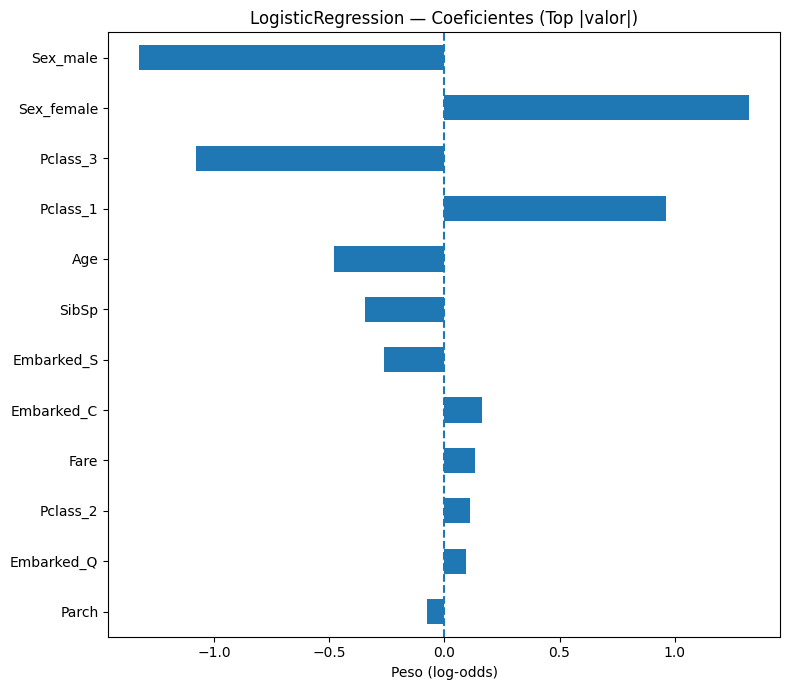

In [76]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Garante que temos os objetos calculados na célula 8; se não, recalcula rapidamente.
try:
    coef_series
    feature_names_lr
except NameError:
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.linear_model import LogisticRegression
    # Assume FEATURES_NUM/FEATURES_CAT/X/y já definidos nas células anteriores
    numeric = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler(with_mean=False))])
    categorical = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))])
    pre_tmp = ColumnTransformer([('num', numeric, FEATURES_NUM),
                                 ('cat', categorical, FEATURES_CAT)])
    lr_tmp = Pipeline([('prep', pre_tmp), ('clf', LogisticRegression(max_iter=1000, random_state=42))])
    lr_tmp.fit(X, y)
    ohe_lr = lr_tmp.named_steps['prep'].named_transformers_['cat'].named_steps['ohe']
    cat_names_lr = list(ohe_lr.get_feature_names_out(FEATURES_CAT))
    feature_names_lr = FEATURES_NUM + cat_names_lr
    coef = lr_tmp.named_steps['clf'].coef_[0]
    coef_series = pd.Series(coef, index=feature_names_lr).sort_values(key=lambda s: s.abs(), ascending=False)

topn = 20
top = coef_series.head(topn)[::-1]  # invert to have largest at top of chart
plt.figure(figsize=(8, max(6, int(topn*0.35))))
top.plot(kind='barh')  # sem cores explícitas
plt.axvline(0, linestyle='--')
plt.title('LogisticRegression — Coeficientes (Top |valor|)')
plt.xlabel('Peso (log-odds)')
plt.tight_layout()
plt.show()



## 9) Boas práticas & pegadinhas

- **Background**: para `Explainer` genérico, use uma **amostra representativa** (100–500 linhas) para acelerar e evitar vieses.
- **OHE & nomes**: sempre recupere `get_feature_names_out` após `fit` para mapear corretamente os dummies.
- **Escala**: como padronizamos numéricos, os valores de SHAP comparam **impacto no logit/probabilidade**, não os valores brutos.
- **CV vs Holdout**: explique no **modelo final** (treinado em todo o treino) para relatórios, mas valide métricas com **OOF/CV**.
- **Árvores**: prefira `TreeExplainer` (mais rápido/estável). Para modelos não-árvore, use `Explainer` com *masker/background*.
- **Local vs Global**: combine **summary/bar** (global) com **force/waterfall** (local) para narrativas completas.
